In [11]:
import numpy as np
import matplotlib.pyplot as plt
import os, shutil
from tqdm import tqdm
from rl_glue import RLGlue

from tbu_gym.tbu_discrete import TruckBackerEnv_D

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
from tbu_gym.tbu_discrete import TruckBackerEnv_D


# ---------------------------
# Q-Network Definition
# ---------------------------
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim)
        )

    def forward(self, x):
        return self.model(x)


# ---------------------------
# QRC Agent
# ---------------------------
class QRCAgent:
    def __init__(
        self,
        state_dim,
        action_dim,
        lr_q=1e-3,
        gamma=0.99,
        epsilon=1.0,
        epsilon_decay=0.99997,
        min_epsilon=0.01,
        batch_size=64,
        buffer_size=50000,
        alpha=1.0,
        sigma_min=0.0,
        sigma_max=1.0
    ):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.batch_size = batch_size
        self.alpha = alpha
        self.sigma_min = sigma_min
        self.sigma_max = sigma_max

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # --- Q and Target Networks ---
        self.q_network = QNetwork(state_dim, action_dim).to(self.device)
        self.target_network = QNetwork(state_dim, action_dim).to(self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()

        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr_q)
        self.memory = deque(maxlen=buffer_size)

    # ---------------------------
    # ε-greedy policy
    # ---------------------------
    def agent_policy(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.action_dim)
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            q_values = self.q_network(state)
        return q_values.argmax().item()

    # ---------------------------
    # Store experience
    # ---------------------------
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    # ---------------------------
    # Update target network
    # ---------------------------
    def update_target(self):
        """Hard update (copy parameters)."""
        self.target_network.load_state_dict(self.q_network.state_dict())

    # ---------------------------
    # Training with replay memory
    # ---------------------------
    def train_with_mem(self):
        if len(self.memory) < self.batch_size:
            return 0.0

        # Sample batch
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(np.stack(states)).to(self.device)
        next_states = torch.FloatTensor(np.stack(next_states)).to(self.device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(self.device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(self.device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(self.device)

        # --- Q values ---
        q_values = self.q_network(states).gather(1, actions)

        # --- Target Q values ---
        with torch.no_grad():
            next_q_target = self.target_network(next_states)
            max_next_q, _ = next_q_target.max(1, keepdim=True)

            # Correction term (σ-based)
            next_q_online = self.q_network(next_states)
            sigma = next_q_online.std(dim=1, keepdim=True)
            sigma_clipped = torch.clamp(sigma, self.sigma_min, self.sigma_max)
            correction = self.alpha * sigma_clipped

            target_qrc = rewards + self.gamma * (max_next_q - correction) * (1 - dones)

        # --- Loss and optimization ---
        loss = nn.MSELoss()(q_values, target_qrc)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # --- Epsilon decay ---
        if self.epsilon > self.min_epsilon:
            self.epsilon *= self.epsilon_decay

        return loss.item()

Episode    1/1000, Reward: -300.00, Epsilon: 0.99292, Loss: 0.00169
Episode    2/1000, Reward: -300.00, Epsilon: 0.98402, Loss: 0.00050
Episode    3/1000, Reward: -300.00, Epsilon: 0.97520, Loss: 0.00041
Episode    4/1000, Reward: -300.00, Epsilon: 0.96646, Loss: 0.00146
Episode    5/1000, Reward: -300.00, Epsilon: 0.95781, Loss: 0.00077
Episode    6/1000, Reward: -300.00, Epsilon: 0.94922, Loss: 0.00086
Episode    7/1000, Reward: -300.00, Epsilon: 0.94072, Loss: 0.01149
Episode    8/1000, Reward: -300.00, Epsilon: 0.93229, Loss: 0.00050
Episode    9/1000, Reward: -300.00, Epsilon: 0.92394, Loss: 0.00164
Episode   10/1000, Reward: -300.00, Epsilon: 0.91566, Loss: 0.01211
Episode   11/1000, Reward: -300.00, Epsilon: 0.90745, Loss: 0.00461
Episode   12/1000, Reward: -300.00, Epsilon: 0.89932, Loss: 0.00756
Episode   13/1000, Reward: -300.00, Epsilon: 0.89127, Loss: 0.00192
Episode   14/1000, Reward: -300.00, Epsilon: 0.88328, Loss: 0.00202
Episode   15/1000, Reward: -300.00, Epsilon: 0.8

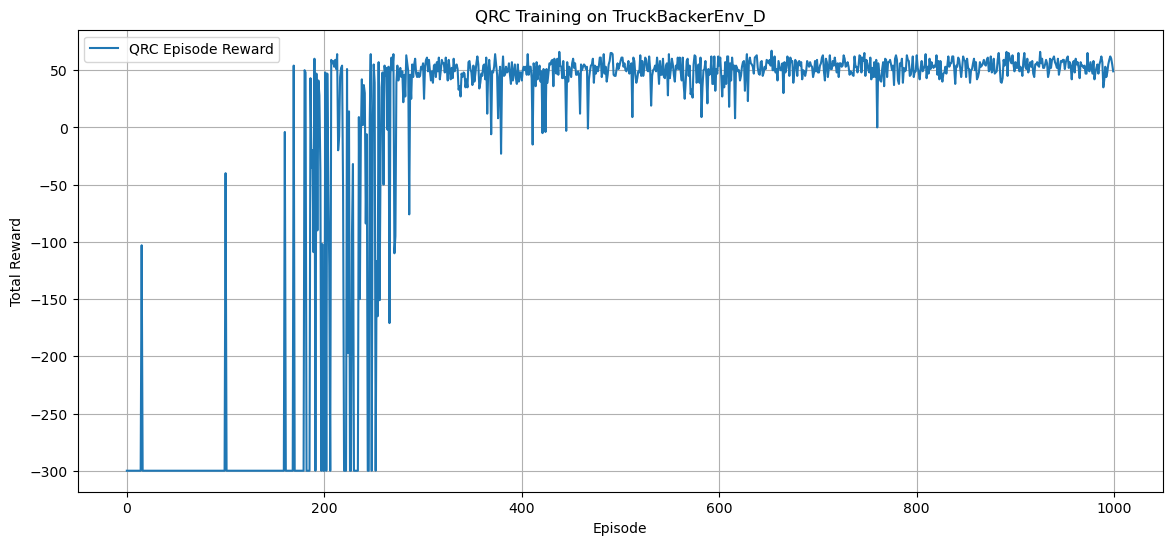

In [25]:
import matplotlib.pyplot as plt
from tbu_gym.tbu_discrete import TruckBackerEnv_D

# --- 1. Hyperparameters ---

num_episodes = 1000
max_steps_per_episode = 500
gamma = 0.99
learning_rate = 1e-3
epsilon_start = 1.0
epsilon_decay = 0.99997
epsilon_min = 0.01
batch_size = 64
target_update_freq = 5  # Update target net every few episodes

# QRC Specific Parameters
alpha = 1.0
sigma_min = 0.0
sigma_max = 1.0

# --- 2. Environment Setup ---
env = TruckBackerEnv_D(render_mode=None)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# --- 3. Agent Initialization ---
agent = QRCAgent(
    state_dim=state_dim,
    action_dim=action_dim,
    lr_q=learning_rate,
    gamma=gamma,
    epsilon=epsilon_start,
    epsilon_decay=epsilon_decay,
    min_epsilon=epsilon_min,
    batch_size=batch_size
)

# --- 4. Training Loop ---
episode_rewards = []
recent_loss = 0.0

for episode in range(1, num_episodes + 1):
    reset_output = env.reset()
    if isinstance(reset_output, tuple):
        state, _ = reset_output
    else:
        state = reset_output

    total_reward = 0

    for t in range(max_steps_per_episode):
        # Select action
        action = agent.agent_policy(state)

        # Step environment (compatible with Gym / Gymnasium)
        step_result = env.step(action)
        if len(step_result) == 5:
            next_state, reward, terminated, truncated, _ = step_result
            done = terminated or truncated
        else:
            next_state, reward, done, _ = step_result

        total_reward += reward

        # Store transition and train
        agent.remember(state, action, reward, next_state, done)
        loss = agent.train_with_mem()
        if loss != 0.0:
            recent_loss = loss

        state = next_state
        if done:
            break

    # Update target network every few episodes
    if episode % target_update_freq == 0:
        agent.update_target()

    # Record and print progress
    episode_rewards.append(total_reward)
    print(f"Episode {episode:4d}/{num_episodes}, Reward: {total_reward:7.2f}, "
          f"Epsilon: {agent.epsilon:.5f}, Loss: {recent_loss:.5f}")

# --- 5. Plotting Results ---
plt.figure(figsize=(14, 6))
plt.plot(episode_rewards, label="QRC Episode Reward")
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('QRC Training on TruckBackerEnv_D')
plt.legend()
plt.grid(True)
plt.savefig('QRC_Discrete_TruckBackerEnv_D.png', dpi=300, bbox_inches='tight')
plt.show()

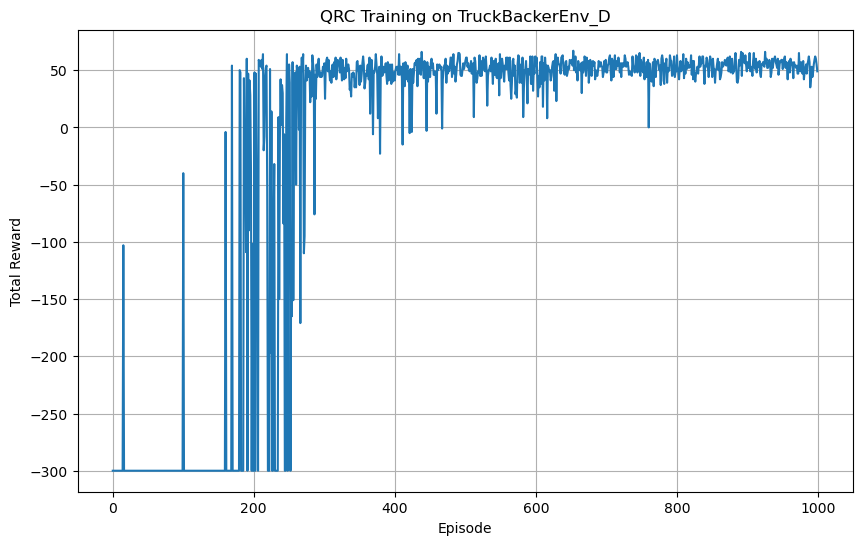

In [26]:
# Plotting Results
plt.figure(figsize=(10, 6))
plt.plot(episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('QRC Training on TruckBackerEnv_D')
plt.grid(True)

# Save the plot to a file
plt.savefig('QRC_Discrete_TruckBackerEnv_D.png', dpi=300, bbox_inches='tight')

plt.show()

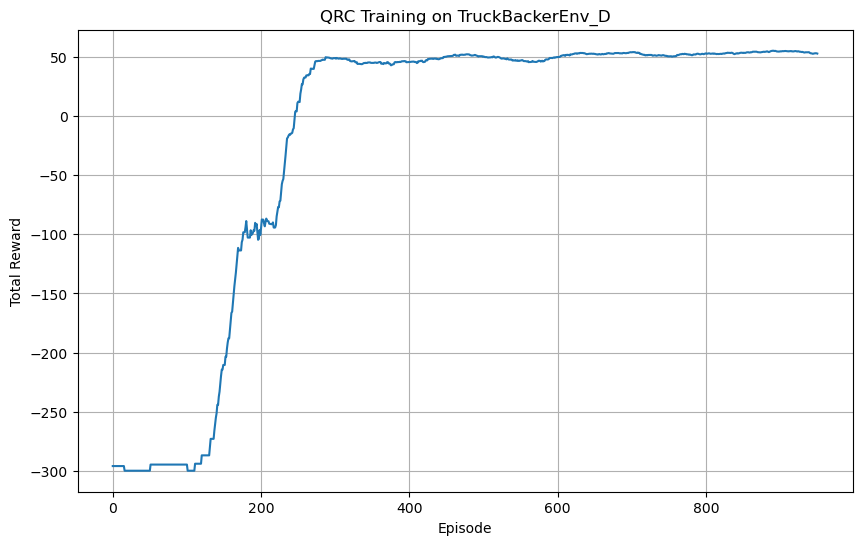

In [27]:
window = 50
smoothed = np.convolve(episode_rewards, np.ones(window)/window, mode='valid')

# Plotting Results
plt.figure(figsize=(10, 6))
plt.plot(smoothed)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('QRC Training on TruckBackerEnv_D')
plt.grid(True)

# Save the plot to a file
plt.savefig('QRC_Discrete_TruckBackerEnv_D.png', dpi=300, bbox_inches='tight')

plt.show()